# Final Tutorial Notebook
#### Emily Gong, Robert Morrison

In this notebook we will explore the transcripts from UN General Debates. Our goal is to understand what differences exist between speakers of different language backgrounds

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import bs4
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Loading Data
## Raw Data

In [2]:
data = pd.read_csv("un-general-debates.csv")
data.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [3]:
print(len(data))

7507


In [4]:
countries = data["country"].unique()
print(countries)
print(len(countries))

['MDV' 'FIN' 'NER' 'URY' 'ZWE' 'PHL' 'SDN' 'RUS' 'CHN' 'ESP' 'SUR' 'ARG'
 'SLV' 'MYS' 'NPL' 'PRT' 'COL' 'BLR' 'MAR' 'LCA' 'EGY' 'MEX' 'BEL' 'BRN'
 'RWA' 'CAN' 'ALB' 'GRC' 'KNA' 'GUY' 'LBR' 'ATG' 'MOZ' 'JPN' 'YDYE' 'GAB'
 'BGD' 'SWE' 'TUR' 'TCD' 'SYR' 'CMR' 'JAM' 'LUX' 'ITA' 'AGO' 'CRI' 'CSK'
 'BFA' 'MNG' 'BHR' 'HTI' 'OMN' 'CIV' 'TGO' 'CYP' 'MUS' 'MMR' 'ARE' 'GTM'
 'GRD' 'LBY' 'LKA' 'TZA' 'SGP' 'NOR' 'LAO' 'ISL' 'AFG' 'CHL' 'DMA' 'UKR'
 'KEN' 'BLZ' 'FRA' 'MLI' 'VCT' 'VEN' 'MLT' 'GHA' 'GIN' 'GBR' 'ISR' 'YUG'
 'BRB' 'IRQ' 'HUN' 'AUT' 'POL' 'GNB' 'BWA' 'MRT' 'SWZ' 'DNK' 'DOM' 'MDG'
 'NIC' 'BDI' 'CUB' 'IRN' 'PAK' 'SEN' 'BGR' 'YEM' 'STP' 'NLD' 'VUT' 'BOL'
 'PNG' 'SLB' 'DEU' 'ROU' 'KHM' 'TUN' 'BRA' 'IND' 'IDN' 'AUS' 'COD' 'HND'
 'GNQ' 'FJI' 'IRL' 'DZA' 'USA' 'LSO' 'GMB' 'PER' 'DDR' 'THA' 'JOR' 'COG'
 'NGA' 'ECU' 'SAU' 'QAT' 'SYC' 'ETH' 'TTO' 'PRY' 'VNM' 'NZL' 'PAN' 'MWI'
 'DJI' 'BEN' 'SOM' 'ZMB' 'CPV' 'BHS' 'KWT' 'UGA' 'COM' 'ZAF' 'LBN' 'SLE'
 'KOR' 'BIH' 'TON' 'EU' 'HRV' 'NRU' 'TUV' 'NAM' 'S

In [5]:
years = data["year"].unique()
print(years)
print(len(years))
# 46 Examples of each country

[1989 1970 2013 1985 2008 1991 1986 2002 1975 1996 2012 1997 1978 1988
 2010 1984 1995 2009 1971 1976 1983 1979 1999 2005 1987 1982 1998 2003
 2004 1980 2014 2011 1974 2015 1993 1977 1981 2000 1992 1990 1973 1994
 1972 2006 2007 2001]
46


## Scraping

In [6]:
# Getting a decoding table and access to each countries Wikipedia page
url = "https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3"
r = requests.get(url)
soup = bs4.BeautifulSoup(r.text)

In [7]:
found = soup.find("div", class_="plainlist").find("ul")

In [8]:
lookup = {} # dict {country code : [Country Name, wikipedia link]}

for child in found.children:
    if isinstance(child, bs4.Tag):
        c_code = child.find("span").text
        link = child.find("a").get("href")
        country = child.find("a").text
        
        lookup[c_code] = [country, link]

lookup["CSK"] = ["Czechoslovakia", "/wiki/Czechoslovakia"]
lookup["YDYE"] = ["South Yemen", "/wiki/South_Yemen"]
lookup["YUG"] = ["Yugoslavia", "/wiki/Yugoslavia"]
lookup["DDR"] = ["East Germany", "/wiki/East_Germany"]
lookup["EU"] = ["European Union", "/wiki/European_Union"]

In [9]:
data["name"] = [lookup[code][0] for code in data["country"]]

# EDA

### Existence of Countries

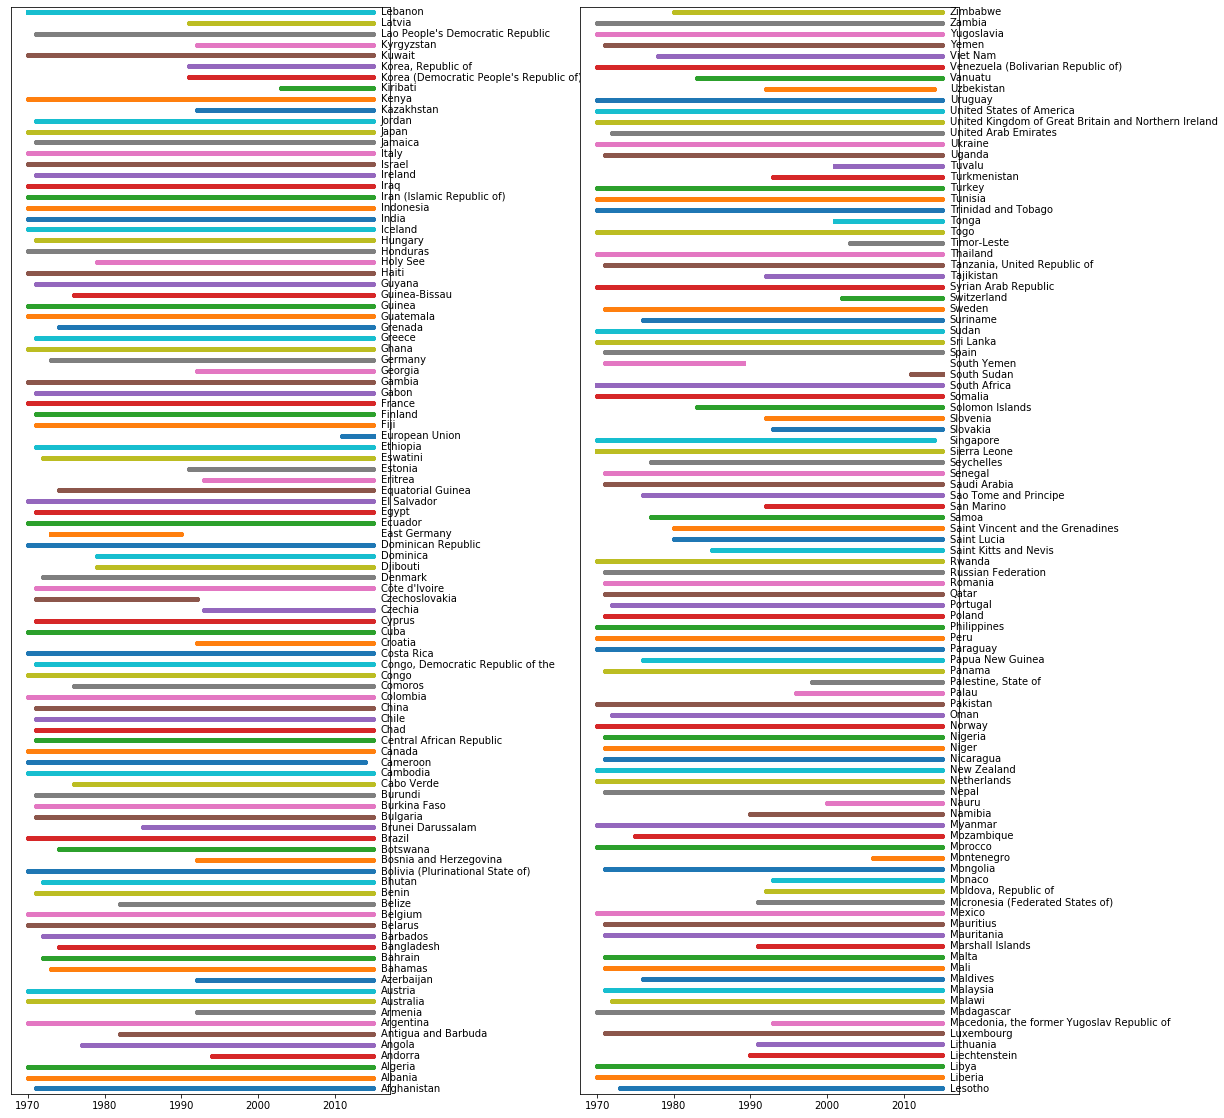

In [147]:
grouped = data.groupby("name")

fig, axs = plt.subplots(1, 2, figsize=(17,20))
plt.subplots_adjust(wspace=.5)

for ax in axs:
    ax.yaxis.set_visible(False)
    ax.margins(x=0.05,y=0.005)

for h, (name, group) in enumerate(grouped):
    x = group["year"]
    y = np.empty(len(x))
    y.fill(h)
    
    i = round(h / len(grouped))
    ax = axs[i]
    
    ax.plot(x, y, linewidth=5)
    ax.annotate(name, xy=(2016,h-0.25))
    
plt.show()

### Word Counts

In [37]:
count_vect = CountVectorizer(max_df=.90, min_df=2, max_features=1000)
tfidf_vect = TfidfVectorizer(max_df=.90, min_df=2, max_features=1000)

counts = count_vect.fit_transform(data["text"][:100])
count_total = np.array(counts.sum(axis=0))[0]
count_vocab = count_vect.vocabulary_
count_feats = np.array(count_vect.get_feature_names())

tfidfs = tfidf_vect.fit_transform(data["text"][:100])
tfidf_vocab = tfidf_vect.vocabulary_
tfidf_feats = np.array(count_vect.get_feature_names())

In [38]:
max_indices = np.array(tfidfs.argmax(axis=1).T)[0]
max_words = tfidf_feats[max_indices]

In [65]:
important_counts = np.empty((0,2))
for doc, word in enumerate(max_words):
    index = count_vocab[word]
    count = counts[doc,index]
    important_counts = np.append(important_counts, np.array([[word, count]]), axis=0)
important_counts = pd.DataFrame(important_counts, columns=["word", "count"])

In [67]:
important_counts.head()

,word,count
0,small,9
1,keeping,10
2,african,11
3,democracy,9
4,african,17
